# <u>Chapter 8</u>: Detecting Hateful and Offensive Language

The spread of hate speech and fake news are serious side effects of expanding social networks. Most of the time covered behind anonymity, social network users feel more comfortable speaking hate or disseminating fabricated information as opposed to real life when they have to confront the consequences of their saying. All major social networks conduct an enormous effort to deal with such a problem, and again, manipulating text data using machine learning is a powerful tool in this arena.

The current exercise focuses on identifying hate and offensive speech in tweets using a state-of-the-art language model and classification methods. Although there are tools for extracting tweets from the platform, we use for convenience a publicly available corpus from https://github.com/t-davidson/hate-speech-and-offensive-language.

In [1]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'numpy', 'pandas', 'sklearn', 'matplotlib', 'seaborn', 'keras', 'tensorflow-text', 'tf-models-official==2.7.0'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Installing the following packages: {'tf-models-official==2.7.0'}


## Exploratory data analysis

Before creating our custom BERT language model, we first need to load the instances from the tweets dataset.

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd

# Read the data from the csv file.
data = pd.read_csv('./data/labeled_data.csv')

data.sample(random_state=4)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
12946,13265,3,0,3,0,1,My Ralph Lauren jacket comes tomorrow. Im givi...


Each sample was annotated by three people who labeled each tweet as _hate_speech_=0, _offensive_language_=1, or _neither_=2. It is not uncommon to encounter disagreement among the annotators, so the class of the tweet is determined by a majority vote. In the previous example, all three annotators agreed, however. Next, we print an example for each class.

In [3]:
# Print an example for each class.
print("* Hate speech:", data.iloc[10477].tweet)
print("* Offensive speech:", data.iloc[9463].tweet)
print("* Neither offensive nor non-offensive speech:", data.iloc[20963].tweet)

* Hate speech: I hate the ghetto trash at the special school across the street from my building. All of them will grow up to be criminals.
* Offensive speech: God my tweets are so ghetto
* Neither offensive nor non-offensive speech: So many weird people in the ghetto at this time.


The code that follows shows the number of samples per each class.

In [4]:
# Print the number of examples per class.
data['category'] = data['class'].map({0: 'hate_speech', 1: 'offensive_language', 2: 'neither'})
data['category'].value_counts()

offensive_language    19190
neither                4163
hate_speech            1430
Name: category, dtype: int64

Another important issue is that the tweets do not merely consist of human text, but they can frequently contain handles, emojis, and HTML links. These are also text elements, and the following code can be used to extract this information.

In [5]:
import re

# Remove emojis, handles, HTML character references and links.
def preprocess_text(text):
    regrex_pattern = re.compile(pattern = "&#[A-Za-z0-9]+;|@[A-Za-z0-9]+|&[A-Za-z0-9]+;|(http|https)://[A-Za-z0-9./]+")
    return regrex_pattern.sub(r'', text)

data['tweet'] = data['tweet'].apply(lambda x: preprocess_text(x))

## Creating validation sets

In Python, there is no direct way to extract the three data sets in one step, so we need to perform a small trick. First, we call the _train_test_split_ to get the training and test sets from the corpus and then call the same method on the training set to create the validation one. The following code shows the specific steps.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# Create the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['class'], test_size=0.1, stratify=data['class'], random_state=123)

# Split the train set into validation and smaller training sets.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=123)

print("Number of samples in the training set:", len(X_train))
print("Number of samples in the validation set:", len(X_val))
print("Number of samples in the test set:", len(X_test))


Number of samples in the training set: 20073
Number of samples in the validation set: 2231
Number of samples in the test set: 2479


## Treating imbalanced data sets

Based on the number of instances in each class, we calculate a weight that the model can use to pay more attention to examples from the under-represented classes.

In [7]:
# Calculate the number of instances per class.
hate, offensive, neither = np.bincount(data['class'])
total = hate + offensive + neither

# Assign a weight per class.
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / offensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0

# Combine all weights into a dictionary.
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


## Classifying with BERT and CNN

The tensorflow_hub module contains a gamut of BERT models, which are pre-trained with different datasets. In our case, the demand for smaller BERT models stems from the need to use them in smaller computational environments.

<ins>Note</ins>:  The training time will vary depending on the complexity of the BERT model you have selected.

In [8]:
tf.get_logger().setLevel('ERROR')

# Choose a BERT model to fine-tune.
model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

name_handle_dict = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

name_preprocess_dict = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

encoder_handle = name_handle_dict[model_name]
preprocess_handle = name_preprocess_dict[model_name]

print("Using the BERT model: " + encoder_handle)
print("Using the preprocess model: " + preprocess_handle)

Using the BERT model: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Using the preprocess model: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Let's now create the preprocess and BERT models.

In [9]:
import tensorflow_hub as hub
import tensorflow_text as text

# Use the handle to create the preprocess model.
preprocess_model = hub.KerasLayer(preprocess_handle)

In [10]:
# Use the preprocess model.
text_test = ['God my tweets are so ghetto']
text_preprocessed = preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2643  2026  1056 28394  3215  2024  2061 17276   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# Use the handle to create the BERT model.
bert_model = hub.KerasLayer(encoder_handle)

Then, we use the BERT model.

In [12]:
# Feed the text to the BERT model.
results = bert_model(text_preprocessed)

print(f'Loaded BERT: {encoder_handle}')
print("The shape of the pooled outputs:", results["pooled_output"].shape)
print(f'Pooled Outputs Values:{results["pooled_output"][0, :12]}')
print("The shape of the sequence outputs:", results["sequence_output"].shape)
print(f'Sequence Outputs Values:{results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
The shape of the pooled outputs: (1, 512)
Pooled Outputs Values:[ 0.98803324  0.8174704  -0.09931858  0.49448684  0.06150028  0.97966045
  0.981785   -0.99347323 -0.23559046 -0.9967652   0.04346502 -0.9847543 ]
The shape of the sequence outputs: (1, 128, 512)
Sequence Outputs Values:[[ 0.11464122  0.1346041   0.74873996 ... -0.03851436 -0.02120748
  -1.3489943 ]
 [-0.23390523  0.40867108  0.33201155 ...  0.7629751  -0.685918
   0.1627047 ]
 [ 0.11540073  0.1970486   0.75625384 ... -0.35113207 -0.15752485
  -0.33040127]
 ...
 [ 0.11041314 -0.46885568  0.97626245 ... -0.00837535 -0.08699548
  -1.5638739 ]
 [ 0.409267   -0.07035614  0.10864993 ...  0.43746293  0.46431613
  -0.64191353]
 [ 0.39994255 -0.04031736  0.19623217 ...  0.46916968  0.45109606
  -0.6261434 ]]


We need to create a neural architecture consisting of several parts to perform classification.

In [13]:
def build_classifier_model():
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_handle, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = sequence_output = outputs["sequence_output"]

  net = tf.keras.layers.Conv1D(128, (3), activation='relu')(net)
  net = tf.keras.layers.Conv1D(64, (3), activation='relu')(net)
  net = tf.keras.layers.Conv1D(32, (3), activation='relu')(net)
  net = tf.keras.layers.GlobalMaxPool1D()(net)
  net = tf.keras.layers.Dense(512, activation="relu")(net)

  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input, net)

The number of trainable parameters in this setting is given below.

In [14]:
cnn_classifier_model = build_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5634176  0.5626532  0.62081736]], shape=(1, 3), dtype=float32)


In [15]:
cnn_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

We can also visualize the structure of the model and store the output in a file.

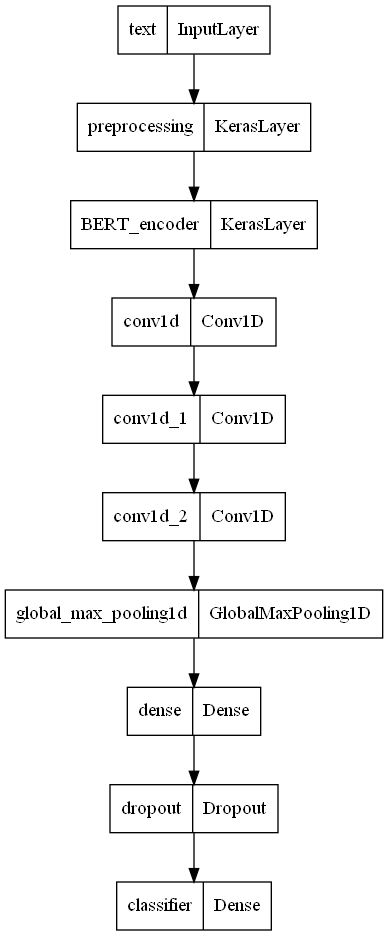

In [16]:
tf.keras.utils.plot_model(cnn_classifier_model, to_file='./data/bert-cnn--model.png')

Then we convert the three datasets to a _tf.data_ type because it provides flexibility in handling the data in TensorFlow.

In [17]:
# Create the three datasets. 
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Combine consecutive samples into batches.
train_ds = train_ds.shuffle(len(X_train), seed=1).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(X_val), seed=1).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(X_test), seed=1).batch(32, drop_remainder=False)

Let's define the loss function using accuracy as a metric. In this case, we compute the cross-entropy loss between the labels and predictions.

In [18]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

Then, we set a few important parameters for the optimizer and proceed to the compilation of the model.

In [20]:
from official.nlp import optimization

epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
#steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=metrics)

Finally, we can start training the classifier. While fitting the model to the data, we use the _class_weight_ to make the classifier heavily weight the minority classes.

In [21]:
print(f'Training model with {encoder_handle}')

cnn_history = cnn_classifier_model.fit(x=train_ds, validation_data=val_ds,
                               epochs=epochs, class_weight=class_weight)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/15
628/628 [==============================] - 736s 1s/step - loss: 0.9902 - accuracy: 0.5078 - val_loss: 0.5283 - val_accuracy: 0.8328
Epoch 2/15
628/628 [==============================] - 730s 1s/step - loss: 0.5576 - accuracy: 0.8315 - val_loss: 0.4825 - val_accuracy: 0.8171
Epoch 3/15
628/628 [==============================] - 716s 1s/step - loss: 0.4581 - accuracy: 0.8688 - val_loss: 0.3987 - val_accuracy: 0.8436
Epoch 4/15
628/628 [==============================] - 716s 1s/step - loss: 0.4050 - accuracy: 0.8907 - val_loss: 0.3780 - val_accuracy: 0.8628
Epoch 5/15
628/628 [==============================] - 715s 1s/step - loss: 0.3267 - accuracy: 0.9011 - val_loss: 0.3738 - val_accuracy: 0.8861
Epoch 6/15
628/628 [==============================] - 716s 1s/step - loss: 0.2925 - accuracy: 0.9255 - val_loss: 0.4052 - val_accuracy: 0.8727
Epoch 7/15
628/628 [==============================

The performance after 15 epochs is:

In [22]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 27s 352ms/step - loss: 0.6596 - accuracy: 0.8983
Loss: 0.6596019864082336
Accuracy: 0.8983461260795593


Let's print the confusion matrix.

In [23]:
from sklearn.metrics import confusion_matrix

# Predict the classes of the test set.
result = cnn_classifier_model.predict(X_test)
y_pred = np.argmax(result, axis=-1)

# Print the confusion matrix.
confusion_matrix(y_test, y_pred)

array([[  63,   71,    9],
       [  73, 1802,   45],
       [  10,   44,  362]], dtype=int64)

We can also extract the model's prediction using three example tweets from the test set.

In [24]:
examples = [
    'I hate the ghetto trash at the special school across the street from my building. All of them will grow up to be criminals.',
    'God my tweets are so ghetto',
    'i wanna go to the ghetto club tonight.']

# Predict the classes of the examples.
result = cnn_classifier_model.predict(examples)
y_pred = np.argmax(result, axis=-1)
print(y_pred)

[0 1 2]


In the code that follows, we generate the loss and accuracy plots for the training and validation set.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


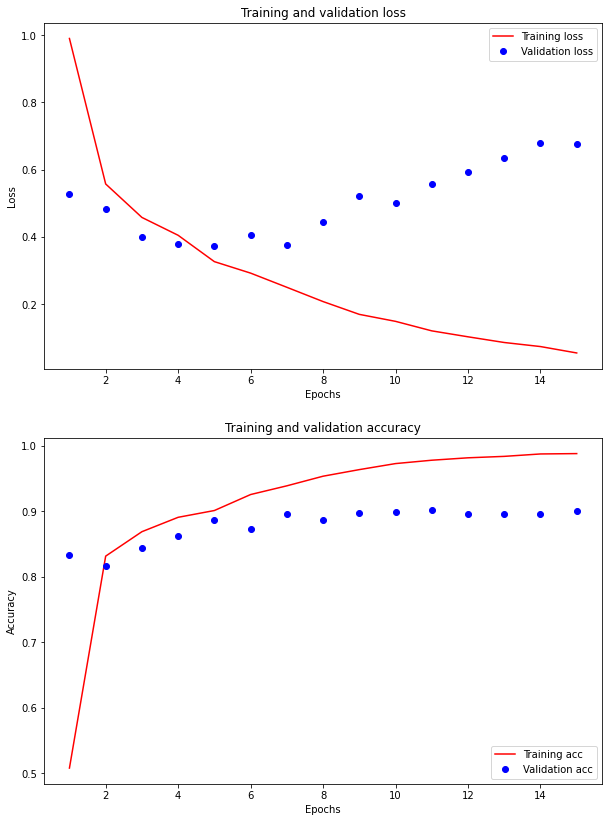

In [25]:
import matplotlib.pyplot as plt 

history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 14))
fig.tight_layout()

# Show the first plot.
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='None', marker='o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the second plot.
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', linestyle='None', marker='o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## What we have learned …

| | | |
| --- | --- | --- |
| **Text representations**<ul><li>BERT</li></ul> | **ML concepts**<ul><li>Imbalanced datasets</li><li>Validation sets</li><li>Early stopping</li><li>Pooling</li></ul> | **ML algorithms & models** <ul><li>Convolutional Neural Networks</li></ul> |
| | | |